# # 플라스크 실행용 코드
---

## # 모델 불러오기
---

In [ ]:
import glob
import os.path
import sys
from collections import namedtuple
import torch
from omegaconf import OmegaConf


from ldm.util import instantiate_from_config

from modules import shared

CheckpointInfo = namedtuple("CheckpointInfo", ['filename', 'title', 'hash', 'model_name'])
checkpoints_list = {}

try:
    # this silences the annoying "Some weights of the model checkpoint were not used when initializing..." message at start.

    from transformers import logging

    logging.set_verbosity_error()
except Exception:
    pass


def checkpoint_tiles():
    return sorted([x.title for x in checkpoints_list.values()])


def list_models():
    checkpoints_list.clear()

    model_dir = os.path.abspath(shared.cmd_opts.ckpt_dir)

    def modeltitle(path, h):
        abspath = os.path.abspath(path)

        if abspath.startswith(model_dir):
            name = abspath.replace(model_dir, '')
        else:
            name = os.path.basename(path)

        if name.startswith("\\") or name.startswith("/"):
            name = name[1:]

        shortname = os.path.splitext(name.replace("/", "_").replace("\\", "_"))[0]

        return f'{name} [{h}]', shortname

    cmd_ckpt = shared.cmd_opts.ckpt
    if os.path.exists(cmd_ckpt):
        h = model_hash(cmd_ckpt)
        title, model_name = modeltitle(cmd_ckpt, h)
        checkpoints_list[title] = CheckpointInfo(cmd_ckpt, title, h, model_name)
    elif cmd_ckpt is not None and cmd_ckpt != shared.default_sd_model_file:
        print(f"Checkpoint in --ckpt argument not found: {cmd_ckpt}", file=sys.stderr)

    if os.path.exists(model_dir):
        for filename in glob.glob(model_dir + '/**/*.ckpt', recursive=True):
            h = model_hash(filename)
            title, model_name = modeltitle(filename, h)
            checkpoints_list[title] = CheckpointInfo(filename, title, h, model_name)
            
    # return checkpoints_list


def model_hash(filename):
    try:
        with open(filename, "rb") as file:
            import hashlib
            m = hashlib.sha256()

            file.seek(0x100000)
            m.update(file.read(0x10000))
            return m.hexdigest()[0:8]
    except FileNotFoundError:
        return 'NOFILE'


def select_checkpoint():
    model_checkpoint = shared.opts.sd_model_checkpoint
    checkpoint_info = checkpoints_list.get(model_checkpoint, None)
    if checkpoint_info is not None:
        return checkpoint_info

    if len(checkpoints_list) == 0:
        print(f"No checkpoints found. When searching for checkpoints, looked at:", file=sys.stderr)
        print(f" - file {os.path.abspath(shared.cmd_opts.ckpt)}", file=sys.stderr)
        print(f" - directory {os.path.abspath(shared.cmd_opts.ckpt_dir)}", file=sys.stderr)
        print(f"Can't run without a checkpoint. Find and place a .ckpt file into any of those locations. The program will exit.", file=sys.stderr)
        exit(1)

    checkpoint_info = next(iter(checkpoints_list.values()))
    if model_checkpoint is not None:
        print(f"Checkpoint {model_checkpoint} not found; loading fallback {checkpoint_info.title}", file=sys.stderr)

    return checkpoint_info


def load_model_weights(model, checkpoint_file, sd_model_hash):
    print(f"Loading weights [{sd_model_hash}] from {checkpoint_file}")

    pl_sd = torch.load(checkpoint_file, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]

    model.load_state_dict(sd, strict=False)

    if shared.cmd_opts.opt_channelslast:
        model.to(memory_format=torch.channels_last)

    if not shared.cmd_opts.no_half:
        model.half()

    model.sd_model_hash = sd_model_hash
    model.sd_model_checkpint = checkpoint_file
    

def load_model():
    from modules import lowvram, sd_hijack
    list_models() # 수정
    checkpoint_info = select_checkpoint()

    sd_config = OmegaConf.load(shared.cmd_opts.config)
    sd_model = instantiate_from_config(sd_config.model)
    load_model_weights(sd_model, checkpoint_info.filename, checkpoint_info.hash)

    if shared.cmd_opts.lowvram or shared.cmd_opts.medvram:
        lowvram.setup_for_low_vram(sd_model, shared.cmd_opts.medvram)
    else:
        sd_model.to(shared.device)

    sd_hijack.model_hijack.hijack(sd_model)

    sd_model.eval()

    print(f"Model loaded.")
    return sd_model


def reload_model_weights(sd_model, info=None):
    from modules import lowvram, devices
    checkpoint_info = select_checkpoint()

    if sd_model.sd_model_checkpint == checkpoint_info.filename:
        return

    if shared.cmd_opts.lowvram or shared.cmd_opts.medvram:
        lowvram.send_everything_to_cpu()
    else:
        sd_model.to(devices.cpu)

    load_model_weights(sd_model, checkpoint_info.filename, checkpoint_info.hash)

    if not shared.cmd_opts.lowvram and not shared.cmd_opts.medvram:
        sd_model.to(devices.device)

    print(f"Weights loaded.")
    return sd_model

shared.sd_model = load_model()

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading weights [7460a6fa] from /data/kimgh/stable-diffusion-webui/models/sd-v1-4.ckpt
Global Step: 470000
Model loaded.


## # txt2img
---

In [ ]:
import modules.scripts
from modules.processing import StableDiffusionProcessing, Processed, StableDiffusionProcessingTxt2Img, StableDiffusionProcessingImg2Img, process_images
from modules.shared import opts, cmd_opts
import modules.shared as shared
import modules.processing as processing
from modules.ui import plaintext_to_html


def txt2img(prompt: str, negative_prompt: str, prompt_style: str, prompt_style2: str, steps: int, sampler_index: int, restore_faces: bool, tiling: bool, n_iter: int, batch_size: int, cfg_scale: float, seed: int, subseed: int, subseed_strength: float, seed_resize_from_h: int, seed_resize_from_w: int, seed_enable_extras: bool, height: int, width: int, enable_hr: bool, scale_latent: bool, denoising_strength: float, *args):
    # global shared.sd_model
    p = StableDiffusionProcessingTxt2Img(
        sd_model=shared.sd_model,
        outpath_samples=opts.outdir_samples or opts.outdir_txt2img_samples,
        outpath_grids=opts.outdir_grids or opts.outdir_txt2img_grids,
        prompt=prompt,
        styles=[prompt_style, prompt_style2],
        negative_prompt=negative_prompt,
        seed=seed,
        subseed=subseed,
        subseed_strength=subseed_strength,
        seed_resize_from_h=seed_resize_from_h,
        seed_resize_from_w=seed_resize_from_w,
        seed_enable_extras=seed_enable_extras,
        sampler_index=sampler_index,
        batch_size=batch_size,
        n_iter=n_iter,
        steps=steps,
        cfg_scale=cfg_scale,
        width=width,
        height=height,
        restore_faces=restore_faces,
        tiling=tiling,
        enable_hr=enable_hr,
        scale_latent=scale_latent if enable_hr else None,
        denoising_strength=denoising_strength if enable_hr else None,
    )

    print(f"\ntxt2img: {prompt}", file=shared.progress_print_out)
    processed = modules.scripts.scripts_txt2img.run(p)

    if processed is None:
        processed = process_images(p)

    shared.total_tqdm.clear()

    generation_info_js = processed.js()
    if opts.samples_log_stdout:
        print(generation_info_js)

    return processed.images, generation_info_js, plaintext_to_html(processed.info)

### # 파라미터
----

In [ ]:
prompt = 'autumn' # 사용자 입력
negative_prompt = '' # 사용자 입력
prompt_style = 'oil painting'
prompt_style2 = 'space'
steps = 20
sampler_index = 0
restore_faces = False
tiling = False
n_iter = 1
batch_size = 4
cfg_scale = 7.0 
denoising_strength = 0.75
seed = 44 # 사용자 입력
subseed = -1
subseed_strength = 0
seed_resize_from_h = -1
seed_resize_from_w = -1
seed_enable_extras = True
height = 512 # 사용자 입력
width = 512 # 사용자 입력
enable_hr = False
scale_latent = True

### # 이미지 생성
---

In [ ]:
# modules.scripts의 def run() 수정 필요

images, info_js, _ = txt2img(prompt=prompt, negative_prompt=negative_prompt, prompt_style=prompt_style, prompt_style2=prompt_style2, steps=steps, sampler_index=sampler_index,
                            restore_faces=restore_faces, tiling=tiling, n_iter=n_iter, batch_size=batch_size, cfg_scale=cfg_scale, denoising_strength=denoising_strength, seed=seed,
                            subseed=subseed, subseed_strength=subseed_strength, seed_resize_from_h=seed_resize_from_h, seed_resize_from_w=seed_resize_from_w, seed_enable_extras=seed_enable_extras, 
                            height=height, width=width, scale_latent=scale_latent, enable_hr=False)


txt2img: autumn
Batch 5 out of 5: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]
Total progress: 20it [00:16,  1.25it/s]


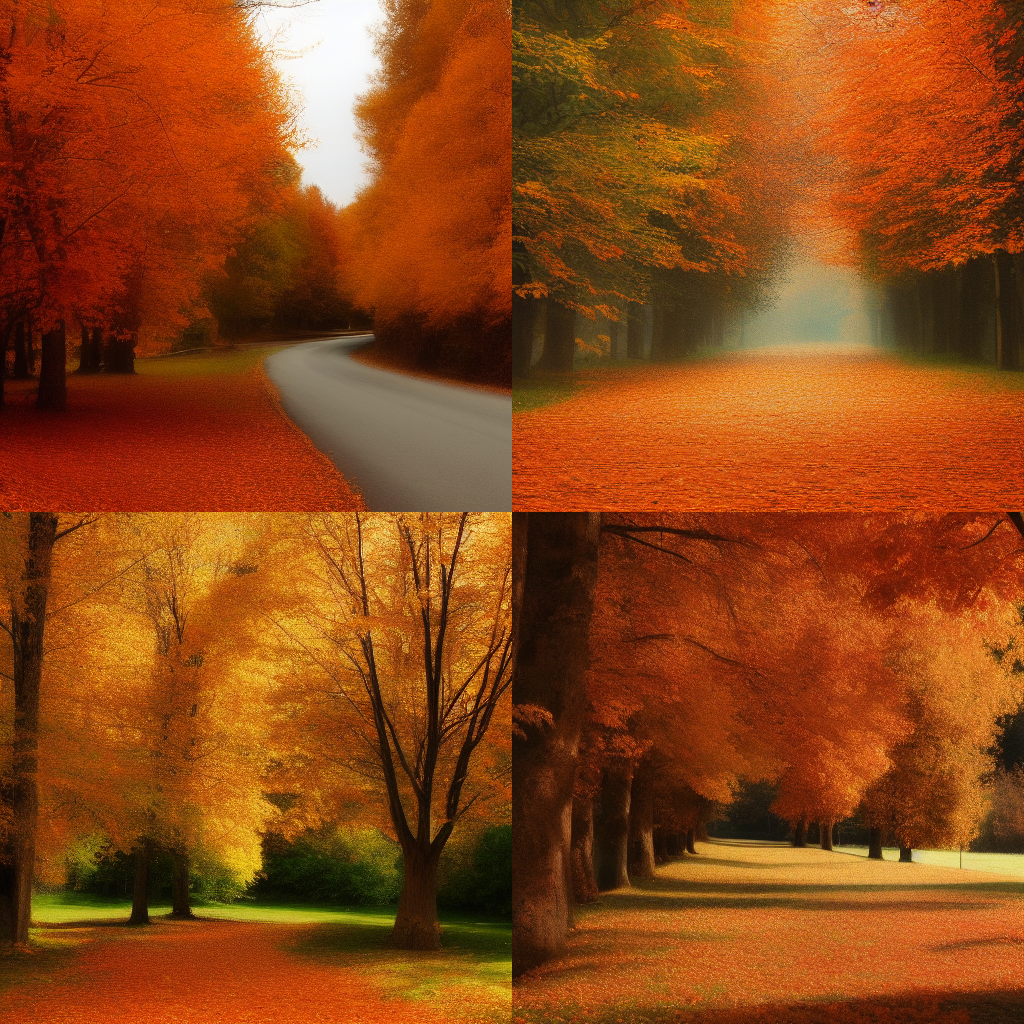

In [ ]:
images[0]

In [ ]:
import json

info = json.loads(info_js)
info

{'prompt': 'autumn',
 'all_prompts': ['autumn', 'autumn', 'autumn', 'autumn'],
 'negative_prompt': '',
 'seed': 44,
 'all_seeds': [44, 45, 46, 47],
 'subseed': 739248615,
 'all_subseeds': [739248615, 739248616, 739248617, 739248618],
 'subseed_strength': 0,
 'width': 512,
 'height': 512,
 'sampler_index': 0,
 'sampler': 'Euler a',
 'cfg_scale': 7.0,
 'steps': 20,
 'batch_size': 4,
 'restore_faces': False,
 'face_restoration_model': None,
 'sd_model_hash': '7460a6fa',
 'seed_resize_from_w': -1,
 'seed_resize_from_h': -1,
 'denoising_strength': None,
 'extra_generation_params': {},
 'index_of_first_image': 1,
 'infotexts': ['autumn\nSteps: 20, Sampler: Euler a, CFG scale: 7.0, Seed: 44, Size: 512x512, Model hash: 7460a6fa, Batch size: 4, Batch pos: 0, Seed resize from: -1x-1',
  'autumn\nSteps: 20, Sampler: Euler a, CFG scale: 7.0, Seed: 44, Size: 512x512, Model hash: 7460a6fa, Batch size: 4, Batch pos: 0, Seed resize from: -1x-1',
  'autumn\nSteps: 20, Sampler: Euler a, CFG scale: 7.0, 